In [1]:
%matplotlib inline
import math
import os
import mne
import pandas as pd
from mne.externals.pymatreader import read_mat 
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
from scipy import io
import scipy

import pyriemann
from pyriemann.classification import KNearestNeighbor

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csgraph

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, f_regression
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet/P01'
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
tmp = eeg.get_data()


In [54]:
########################################
## Fonctions pour manipuler le signal:##
########################################

def reshape(signal): #transforme le signal total en elevant la dimension d'epoch
    (a,b,c)=signal.shape
    output=np.zeros((b,a*c))
    for i in range (a):
        for j in range (b):
            output[j,i*500:(i+1)*500]=signal[i,j,:]
    return (output)


from scipy import signal as SIG
eeg_bands_info = {
  "delta": {
      "corner frq low" : 1,
      "corner frq high" : 4,
      "delta frq low" :0.75,
      "delta frq high" :1.75,
  },
  "theta": {
      "corner frq low" : 4,
      "corner frq high" : 8,
      "delta frq low" : 1.5,
      "delta frq high" : 2,
  },
  "alpha": {
      "corner frq low" : 8,
      "corner frq high" : 13,
      "delta frq low" : 2,
      "delta frq high" : 4,
      },
  "beta": {
      "corner frq low" : 13,
      "corner frq high" : 30,
      "delta frq low" : 4,
      "delta frq high" : 5,
      },
 "lower gamma": {
      "corner frq low" : 30,
      "corner frq high" : 80,
      "delta frq low" : 5,
      "delta frq high" : 7,
      },
  "upper gamma": {
      "corner frq low" : 80,
      "corner frq high" : 110,
      "delta frq low" : 7,
      "delta frq high" : 10,
      }
}
ripple_pband = 1
ripple_sband = 20
for k in eeg_bands_info.keys():
    eeg_bands_info[k]["Passband"]= [eeg_bands_info[k]["corner frq low"]+ eeg_bands_info[k]["delta frq low"]/2 ,eeg_bands_info[k]["corner frq high"]- eeg_bands_info[k]["delta frq high"]/2]
    eeg_bands_info[k]["Stopband"]= [eeg_bands_info[k]["corner frq low"]- eeg_bands_info[k]["delta frq low"]/2 ,eeg_bands_info[k]["corner frq high"]+ eeg_bands_info[k]["delta frq high"]/2]
    eeg_bands_info[k]["F_order"], eeg_bands_info[k]["Wn"] = SIG.cheb2ord(eeg_bands_info[k]['Passband'], eeg_bands_info[k]['Stopband'], ripple_pband, ripple_sband, fs=250)


def signal_freq_filtre(signal,freqs,fenetre):
    F_order, Wn = SIG.cheb2ord(eeg_bands_info[freqs]['Passband'], eeg_bands_info[freqs]['Stopband'], ripple_pband, ripple_sband, fs=250)
    b, a = SIG.cheby2(eeg_bands_info[freqs]['F_order'],25, eeg_bands_info[freqs]['Wn'], btype = 'bandpass',analog =False, output ='ba', fs=250)
    eeg_signal_filtered = SIG.filtfilt(b,a,signal)
    
    return(eeg_signal_filtered)

# def signal_freq_filtre(signal,freqs,fenetre): #renvoi les 62 canaux eeg filtrés dans une bande de frequence
#     tf=np.fft.fft(signal)

#     n = signal.size
#     timestep = 1/250
#     freq = np.fft.fftfreq(n, d=timestep)

#     if freqs=='delta':
#         waves=[0.5, 4.5]
#     elif freqs=='beta':
#         waves=[12 ,35.5]
#     elif freqs=='theta':
#         waves=[4, 8.5]
#     elif freqs=='alpha':
#         waves=[8, 12.5]
#     elif freqs=='gamma':
#         waves=[35, 1000]
#     output=np.zeros(len(tf))
#     for i in range (len(tf)):
#         if i/2 > waves[1] or i/2<=waves[0]:
#             tf[i]=0
#     output=tf
#     return(np.real(np.fft.ifft(output)))

def signalCourt(signal,ind, size): #renvoi une fenetre du signal de taille "size"
    return signal[:,ind:ind+size]


def analytic_signal(x):
    from scipy.fftpack import fft,ifft
    N = len(x)
    X = fft(x,N)
    h = np.zeros(N)
    h[0] = 1
    h[1:N//2] = 2*np.ones(N//2-1)
    h[N//2] = 1
    Z = X*h
    z = ifft(Z,N)
    return z

def phase_analytique(x): #signal analytique en input, renvoi la phase du signal
    phi=np.arctan(x.imag/x.real)
    return phi

def amplitude_analytique(x): #signal analytique en input, renvoi l'enveloppe du signal
    return abs(x)

####################################
## Fonction de calcul de matrices:##
####################################

def correlation_threshold(signal,fenetre, indice,k=10**(-10)): #output la matrice binaire par correlation des signaux
    corr= np.corrcoef(signal[:,indice:indice+fenetre])
    (a,b)=corr.shape
    threshold=np.zeros((a,b))

#     for i in range (a):
#         for j in range (b):
#             if corr[i,j]>k:
#                 threshold[i,j]=1
#     return threshold
    return(corr)  #les matrices renvoyées sont vides, donc je test sans threshold

def correlation(signal):
    return(np.corrcoef(signal))

def covariance(signal):
    return(np.cov(signal))

def covariance_threshold(signal,fenetre, indice,k=10**(-10)):#output la matrice binaire par covariance des signaux
    cov= np.cov(signal[:,indice:indice+fenetre])
    (a,b)=cov.shape
#     threshold=np.zeros((a,b))

#     for i in range (a):
#         for j in range (b):
#             if cov[i,j]>k:
#                 threshold[i,j]=1
#     return threshold
    return(cov)

def matPLV(signal, fenetre, indice, freq): #output: la matrice de phase locking values
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[j],freq,fenetre)))
            dph=ph1-ph2

            PLV=abs(np.sum(np.exp(1j*(dph))))/len(ph1)
            A[i,j]=PLV
    return (A)

def matPLI(signal, fenetre, indice, freq): #output: la matrice de phase lag index
    B=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[j],freq,fenetre)))
        
            dph=ph1-ph2

            PLI=abs(np.sum(np.sign(np.imag(np.exp(1j*(dph))))))/len(ph1)
            B[i,j]=PLI
    return (B)

def matInfoMut(signal, indice, fenetre,bins):# output: la matrice d'information mutuelle
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            

            X_norm=signalCourt(signal,indice,fenetre)[i]
            Y_norm=signalCourt(signal,indice,fenetre)[j]
            c_xy = np.histogram2d(X_norm, Y_norm, bins)[0]
            mi= mutual_info_score(None, None, contingency=c_xy)
            A[i,j]=mi
            
    return (A)

alphaTable=np.array([[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
                    [0,0,2,3,5,8,10,13,17,21,25,29,34,40,46,52,58,65,73,81,89,98,107,116,126,137]])

def monoExp(x, m, t, b, c):
    return m * np.exp(t * x+c) + b

p0 = (1, 1, 1, 1) # valeurs initiales pour l'optimisation sequentielle
params, cv = scipy.optimize.curve_fit(monoExp, alphaTable[0][:], alphaTable[1][:], p0)
m, t, b, c = params
xs2 = np.arange(50)
ys2 = monoExp(xs2, m, t, b, c)


def matwPLWT(signal, ind, fenetre, freq): ##output: matrice PLWT de poids

    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            if i !=j:
                theta1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[i],freq,fenetre)))
                theta2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[j],freq,fenetre)))
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                PLWT=abs((tpos-tneg)/(tpos+tneg))
                A[i,j]=PLWT
    return (A)

def matPLWT(signal, ind, fenetre, freq,alpha=.05): #output:matrice PLWT binaire (utilisant l'approximation gaussienne pour n>30)

    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            if i !=j:
                theta1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[i],freq,fenetre)))
                theta2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[j],freq,fenetre)))
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                T=min(tpos, tneg)
                n=len(theta1)
                if (n<=30) :
                    Tc=alphaTable[1][n-5]
                    if T<Tc:
                        PLWT=1
                    else:
                        PLWT=0
                else:
                    sig=(n*(n+1)*(2*n+1)/24)
                    mu=n*(n+1)/4
                    Z=(T-mu)/(sig)
                    Zc=1.645 # basé sur gaussienne centrée réduite (ne marche pas)
                    if Z<Zc:
                        PLWT=1
                    else:
                        PLWT=0
                A[i,j]=PLWT
    return (A)


##########################################
## Fonction pour manipuler les matrices:##
##########################################

def emptyDiago(A): #output la matrice mais avec une diagonale vide
    for i in range (A.shape[0]):
        A[i,i]=0
    return (A)

def degreeMat(A): #output: matrice de degrée (termes des lignes sommées sur la diagonale)
    a,b=A.shape
    B=np.zeros((a,b))
    for i in range (a):
        s=0
        for j in range (b):
            s=s+A[i,j]
        B[i,i]=s
    return (B)

def laplacien(A): #renvoi la matrice ayant subit le laplacien
    return (degreeMat(emptyDiago(A))-emptyDiago(A))

def threshold(mat,k): #renvoi la matrice binaire si le threshold est dépassé ou non
    return np.where(mat>k, 1,0)

def vectorise(mat): #extrait la partie triangulaire supérieur de la matrice sous forme de vecteur unidimensionel
    return mat[np.triu_indices(mat.shape[0],k=1)]

def shuffle_in_unison(a, b): #mélange a et b de la meme manière
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


In [4]:
# Cette fonction créer un vecteur de taille ((n*N)*K) où n*N est le nombre d'instances où l'on calcule une statistique
# à travers les 6 sessions du sujet 1 (n:instants/session (= instants/fichier) et N: nombre de sessions)
# K est la taille du vecteur qui provient de la matrice 61x61 --> K=(60*61)/2
# Output: Y qui est le vecteur qui contient 0,1 ou 2 en fonction de la difficulté de charge mentale
#      et X qui est le vecteur ((n*N)*K) des d



def makeTrain(N,n,taillef,frequence,mesure,bins=5,thresh=10**(-10) ): #n est le nombre d'instants par session, N est le nombre de sessions
    data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet'
    numberVect=np.array(['1','1','1','2','2','2']) #le numéro de session du patient 01 (en tout 6 fichiers car 2 sessions de 3 mesures sont labelisées)
    M=numberVect.shape[0]
    diffVect=np.array(['diff', 'easy', 'med', 'diff','easy', 'med']) #les difficultés associé au fichiers .set
    y=np.zeros((N*n,1))
    x=np.zeros((N*n,1830))
    
    for k in range(M):
        array='/patient1/alldata_sbj01_sess'+numberVect[k]+'_MATB'+diffVect[k]+'.set'#pointe vers un dossier avec toutes les sessions d'un meme sujet réuni
        eeg=mne.io.read_epochs_eeglab(data_path+array, verbose=False)
        tmp = eeg.get_data()
        signalTotal2=reshape(tmp)     
        for i in range (n):
            indice=int((signalTotal2.shape[1]-taillef)*i/n) #réparti uniformément l'indice sur les 5 mins de mesure
            if mesure== 'wPLWT':
                mat=matwPLWT(signalTotal2, indice, taillef, frequence)
            elif mesure== 'infoMut':
                mat=matInfoMut(signalTotal2, indice, taillef,bins)
            elif mesure== "PLV":
                mat=matPLV(signalTotal2, taillef, indice, frequence)
            elif mesure=="correlation":
                mat=correlation_threshold(signalTotal2,taillef, indice)
            elif mesure=="covariance":
                mat=covariance_threshold(signalTotal2,taillef, indice,thresh)
                
            x[n*k+i,:]=vectorise(mat).T #rempli par ligne la matrice x
            

            if diffVect[k]== 'easy':
                y[n*k+i]=0
            elif diffVect[k]== 'med':
                y[n*k+i]=1
            elif diffVect[k]== 'diff':
                y[n*k+i]=2              ## associe la difficulté au vecteur y
                
                
#         print(k)
    return (x,y)



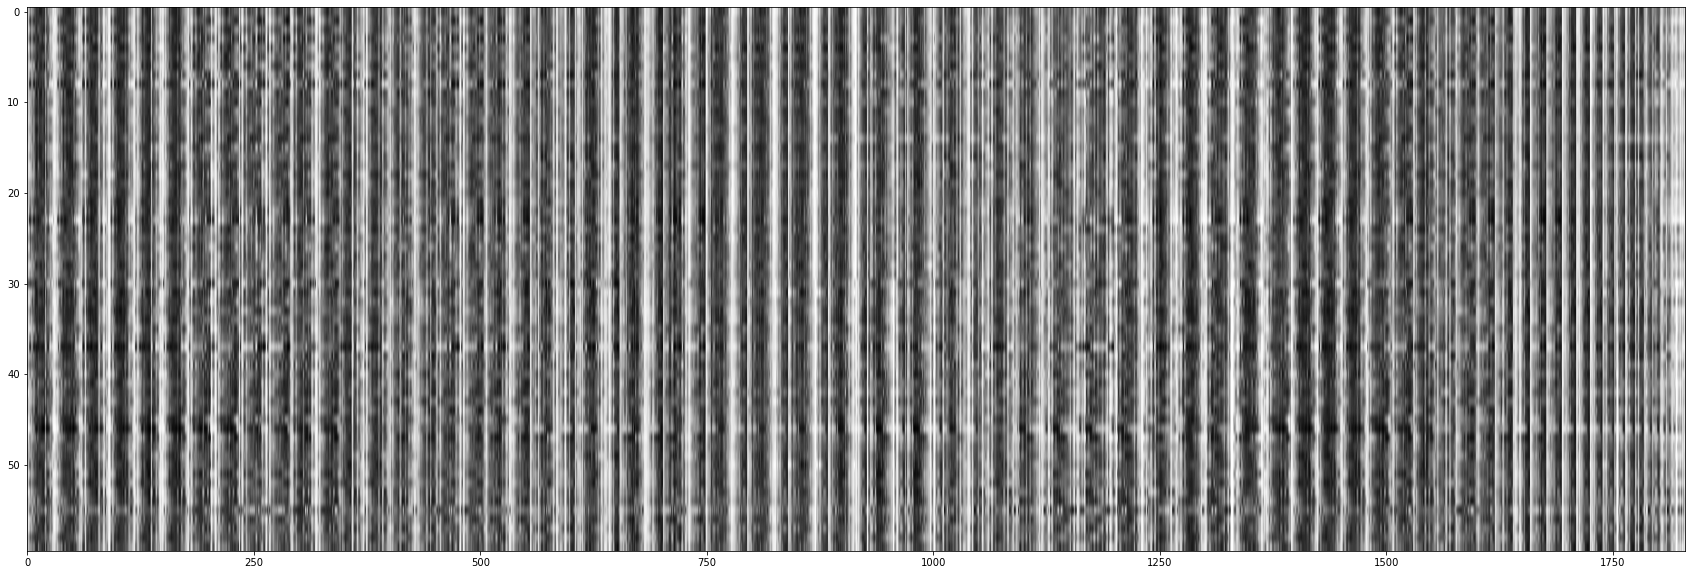

In [5]:
N1=6
n1=10

(X1,Y1)=makeTrain(N1,n1,500,'alpha','correlation',5,0.2*10**(-10))
plt.figure(figsize=(100,10))
plt.imshow(X1,aspect=10,cmap='gray')




In [6]:
(Xnew,Ynew)=shuffle_in_unison(X1,Y1)
print("xnew" ,Xnew.shape)
print("ynew" ,Ynew.shape)

#On mélange les données 

xnew (60, 1830)
ynew (60, 1)


In [8]:
index=int(0.8*N1*n1)
print(index)

Xtrain=Xnew[0:index]
Xtest=Xnew[index:N1*n1]
Ytrain=Ynew[0:index]
Ytest=Ynew[index:N1*n1]   ##on sépare les données train et test

Ytrain=Ytrain.ravel()
Ytest=Ytest.ravel()

neigh = KNeighborsClassifier(n_neighbors=2) #classification KNN classique
neigh.fit(Xtrain, Ytrain)

sco1=neigh.score(Xtest, Ytest)
print(sco1, "sco1")


clf = svm.SVC(kernel="rbf", gamma=0.01) #classification SVM marche le mieu pour kernel rbf et gamma=0.01, pour covariance et 300 instants
clf.fit(Xtrain, Ytrain)
sco2=clf.score(Xtest,Ytest)
print(sco2, "sco2")


48
0.3333333333333333 sco1
0.5 sco2


In [222]:
# pca = PCA(0.75) #75% de la variance retenue
# pca.fit(Xtrain)

601.7402522990382


In [232]:
mlpc = MLPClassifier(hidden_layer_sizes=(100,),random_state=1, max_iter=10000).fit(Xtrain, Ytrain) # classification réseau de neurone
sco3=clf.score(Xtest, Ytest)
print(sco3)


0.7694444444444445


In [55]:
## PyRiemman et classification de matrices

## Créer base de donnée de matrices

# de meme que makeTrain, mais renvoi un vecteur de matrices SPD au lieu que d'un vecteur
# Renvoi la base de donnée train pour une session
def makeTrainMat(n,taillef,frequence,mesure,sessNumber,bins=5,thresh=10**(-10)): #n est le nombre d'instants par session (par séance de 5 mins), M est le nombre de difficultés (3)
    data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet/P01/S'+str(sessNumber)+'/eeg'
    diffVect=np.array(['diff', 'easy', 'med'])
    M=diffVect.shape[0]
    y=np.zeros((M*n,1))
    x=np.zeros((M*n,61,61))
    
    for k in range (M):
        array='/alldata_sbj01_sess'+str(sessNumber)+'_MATB'+diffVect[k]+'.set'#pointe vers un dossier avec l'information de la session "sessNumber"
        eeg=mne.io.read_epochs_eeglab(data_path+array, verbose=False)
        tmp = eeg.get_data()
        signalTotal2=reshape(tmp) 
        for i in range (n):
            indice=int((signalTotal2.shape[1]-taillef)*i/n)
            if mesure== 'wPLWT':
                mat=matwPLWT(signalTotal2, indice, taillef, frequence)
            elif mesure== 'infoMut':
                mat=matInfoMut(signalTotal2, indice, taillef,bins)
            elif mesure== "PLV":
                mat=matPLV(signalTotal2, taillef, indice, frequence)
            elif mesure=="correlation":
                mat=correlation(signal_freq_filtre(signalCourt(signalTotal2,indice,taillef),frequence,taillef))
#                 print(mat.shape)
            elif mesure=="covariance":
                mat=covariance(signal_freq_filtre(signalCourt(signalTotal2,indice,taillef),frequence,taillef))
            elif mesure=="PLWT":
                mat=matPLWT(signalTotal2, indice, taillef, frequence,alpha=.05)
            x[n*k+i,:,:]=mat

            if diffVect[k]== 'easy':
                y[n*k+i]=0
            elif diffVect[k]== 'med':
                y[n*k+i]=1
            elif diffVect[k]== 'diff':
                y[n*k+i]=2
    return (x,y)



0.0


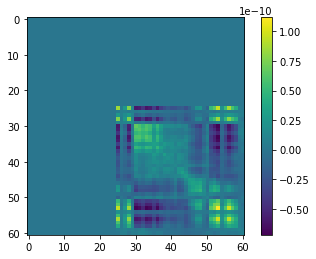

In [88]:
## Créer le train et test
(XTrain,YTrain)=makeTrainMat(10,50,'beta','covariance',1,5)
(XTest,YTest)=makeTrainMat(3,50,'beta','covariance',2,5)
print(XTrain[0,0,1])
plt.imshow(XTrain[1])
plt.colorbar()

## Classifier

# classi=pyriemann.classification.KNearestNeighbor(n_neighbors=5, metric='riemann', n_jobs=1)
# classi.fit(XTrain,YTrain)
# classi.score(XTest,YTest)

#Commentaires: problemes de conditionnement de matrices, elles ne sont toutes pas SPD ? 
# Cela est le cas pour les matrices binaires ou non...

# Lorsqu'on applique la correlation ou covariance sur une bande de fréquence, on a des matrices partiellement vides

In [58]:
freqVect=np.array(['delta','theta','alpha','beta','lower gamma','upper gamma'])
taillef=500
NTrain=10
NTest=4
mesure='correlation'
XTrainF=np.zeros(((len(freqVect)*NTrain*3),61,61))
YTrainF=np.zeros((len(freqVect)*NTrain*3))


def makeMatFreq(taillef, NTrain, mesure, freqs,sessNumber):
    for i in range (len(freqVect)):
        (XTrain,YTrain)=makeTrainMat(NTrain,taillef,freqVect[i],mesure,sessNumber,5)
        XTrainF[i*XTrain.shape[0]:(i+1)*XTrain.shape[0],:,:]=XTrain
        YTrainF[i*YTrain.shape[0]:(i+1)*YTrain.shape[0]]=YTrain.ravel()
    return (XTrainF,YTrainF)

(XTrainF,YTrainF)=makeMatFreq(taillef, NTrain, mesure, freqVect,sessNumber=1)
(XTestF,YTestF)=makeMatFreq(taillef, NTrain, mesure, freqVect,sessNumber=2)

In [59]:
model=pyriemann.classification.KNearestNeighbor()
model.fit(XTrainF,YTrainF)

print(model.score(XTestF,YTestF))

LinAlgError: The leading minor of order 52 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.